# Train HNN-family (HNN, D-HNN, DGNet) for 'experiment-real' problem.

 - Original HNN from hamiltonian_nn by Sam Greydanus

 - Original D-HNN from dissipative_hnns by Andrew Sosanya

 - Original DGNet from discrete-autograd by Takashi Matsubara

 - Modified and adapted by Jae Hoon (Daniel) Lee

In [1]:
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
import argparse
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

EXPERIMENT_DIR = './experiment-real'
sys.path.append(EXPERIMENT_DIR)

from data import get_dataset

In [2]:
def is_jupyter():
    return 'ipykernel' in sys.modules

In [3]:
def save_model_weights(model, directory, filename):
    try:
        if not filename.lower().endswith(('.pth', '.pt', '.tar')):
            filename += '.pth'
        
        if not os.path.exists(directory):
            os.makedirs(directory)
        
        full_path = os.path.join(directory, filename)      
        torch.save(model.state_dict(), full_path)
        
        print(f"Model's weight has successfully been saved: {full_path}")
    
    except Exception as e:
        print(f"Error occurred while saving the model: {e}")

In [4]:
def load_model_weights(model, filepath, device='cpu'):
    if not os.path.exists(filepath):
        print(f"Error: file not found: {filepath}")
        return

    try:
        state_dict = torch.load(filepath, map_location=torch.device(device))
        model.load_state_dict(state_dict)
        model.to(device)

        print(f"Model's weight has successfully been loaded: {filepath} (Device: {device})")
    
    except Exception as e:
        print(f"Error occurred while loading the model: {e}")


# DGNet

In [5]:
import dgnet

In [6]:
def get_dgnet_args():
    parser = argparse.ArgumentParser(description=None)
    parser.add_argument('--noretry', dest='noretry', action='store_true', help='not do a finished trial.')
    # network, experiments
    parser.add_argument('--input_dim', default=2, type=int, help='dimensionality of input tensor')
    parser.add_argument('--hidden_dim', default=200, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--nonlinearity', default='tanh', type=str, help='neural net nonlinearity')
    parser.add_argument('--total_steps', default=2000, type=int, help='number of gradient steps')
    # display
    parser.add_argument('--print_every', default=200, type=int, help='number of gradient steps between prints')
    parser.add_argument('--verbose', dest='verbose', action='store_true', help='verbose?')
    parser.add_argument('--name', default='real', type=str, help='only one option right now')
    parser.add_argument('--seed', default=0, type=int, help='random seed')
    parser.add_argument('--save_dir', default=EXPERIMENT_DIR, type=str, help='where to save the trained model')
    # model
    parser.add_argument('--model', default='hnn', type=str, help='used model.')
    parser.add_argument('--solver', default='dg', type=str, help='used solver.')
    parser.add_argument('--friction', default=False, action="store_true", help='use friction parameter')
    parser.set_defaults(feature=True)

    if is_jupyter():
        return parser.parse_args([]) 
    else:
        return parser.parse_args()

In [7]:
def get_dgnet_model(device='cpu'):

    args = get_dgnet_args()
    model = dgnet.DGNet(args.input_dim, args.hidden_dim,
                        nonlinearity=args.nonlinearity, friction=args.friction, model=args.model, solver=args.solver)
    model = model.to(device)
    return model

In [8]:
def dgnet_train(args):
    ''' import from the current directory structure '''
    from hamiltonian_nn.utils import L2_loss

    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    dtype = torch.get_default_dtype()
    torch.set_grad_enabled(False)

    # set random seed
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)

    # init model and optimizer
    model = dgnet.DGNet(args.input_dim, args.hidden_dim,
                        nonlinearity=args.nonlinearity, friction=args.friction, model=args.model, solver=args.solver)
    model = model.to(device)
    optim = torch.optim.Adam(model.parameters(), args.learn_rate, weight_decay=1e-5)

    # arrange data
    data = get_dataset('pend-real', args.save_dir)
    train_x = torch.tensor(data['x'], requires_grad=True, device=device, dtype=dtype)
    test_x = torch.tensor(data['test_x'], requires_grad=True, device=device, dtype=dtype)
    train_dxdt = torch.tensor(data['dx'], device=device, dtype=dtype)
    test_dxdt = torch.tensor(data['test_dx'], device=device, dtype=dtype)

    input_dim = train_x.shape[-1]
    x1 = train_x[:-1].detach()
    x2 = train_x[1:].detach()
    dxdt = train_dxdt[:-1].clone()
    dt = 1 / 6.

    # vanilla train loop
    stats = {'train_loss': [], 'test_loss': []}
    for step in range(args.total_steps + 1):
        with torch.enable_grad():
            # train step
            dxdt_hat = model.discrete_time_derivative(x1, dt=dt, x2=x2)
            loss = L2_loss(dxdt, dxdt_hat)
        optim.zero_grad()
        loss.backward()
        optim.step()

        # run validation
        if args.solver == 'implicit':
            # because it consumes too long time.
            test_loss = torch.tensor(float('nan'))
        else:
            test_dxdt_hat = model.discrete_time_derivative(test_x, dt=dt)
            test_loss = L2_loss(test_dxdt, test_dxdt_hat)

        # logging
        stats['train_loss'].append(loss.item())
        stats['test_loss'].append(test_loss.item())
        if args.verbose and step % args.print_every == 0:
            print("step {}, train_loss {:.4e}, test_loss {:.4e}".format(step, loss.item(), test_loss.item()))
            if args.friction:
                print("friction g =", model.g.detach().cpu().numpy())

    dxdt_hat = model.discrete_time_derivative(train_x, dt=dt)
    train_dist = (train_dxdt - dxdt_hat)**2
    test_dxdt_hat = model.discrete_time_derivative(test_x, dt=dt)
    test_dist = (test_dxdt - test_dxdt_hat)**2
    print('Final train loss {:.4e}\nFinal test loss {:.4e}'
          .format(train_dist.mean().item(), test_dist.mean().item()))
    stats['final_train_loss'] = train_dist.mean().item()
    stats['final_test_loss'] = test_dist.mean().item()

    return model

In [9]:
def train_dgnet_main():
    args = get_dgnet_args()

    # Explicitly set args.verbose as True
    args.verbose = True 
    args.print_every = 200

    # Explicitly set args.friction as True
    args.friction = True

    # save
    os.makedirs(args.save_dir + '/results') if not os.path.exists(args.save_dir + '/results') else None
    label = ''
    label = label + '-{}-{}'.format(args.model, args.solver)
    label = label + '-friction' if args.friction else label
    label = label + '-seed{}'.format(args.seed)
    name = args.name
    result_path = '{}/results/dg-{}{}'.format(args.save_dir, name, label)
    path_tar = '{}.tar'.format(result_path)
    path_pkl = '{}.pkl'.format(result_path)
    path_txt = '{}.txt'.format(result_path)
    args.result_path = result_path

    if os.path.exists(path_txt):
        if args.noretry:
            exit()
        else:
            os.remove(path_txt)

    model = dgnet_train(args)
    torch.save(model.state_dict(), path_tar)
   
    return model

In [10]:
dgnet_model = train_dgnet_main()
save_dir = EXPERIMENT_DIR + "/weights"
save_model_weights(dgnet_model, save_dir,"dgnet_real")

data zip filepath: ./experiment-real/invar_datasets.zip


/home/danieljh/py-venv/lib/python3.12/site-packages/torchdiffeq/_impl/misc.py:306: UserWarning: t is not on the same device as y0. Coercing to y0.device.
  warnings.warn("t is not on the same device as y0. Coercing to y0.device.")
/media/danieljh/shared/Code/piml-comp-git/assess-hamiltonian-nn-family/dgnet/modules.py:36: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  x1 = fsolve(wrapped_func, to_numpy(x0), *args, **kwargs)


step 0, train_loss 7.7965e-01, test_loss 9.2601e-01
friction g = [0.001]


/media/danieljh/shared/Code/piml-comp-git/assess-hamiltonian-nn-family/dgnet/modules.py:36: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  x1 = fsolve(wrapped_func, to_numpy(x0), *args, **kwargs)


step 200, train_loss 4.2489e-03, test_loss 7.5466e-01
friction g = [0.01766522]
step 400, train_loss 2.8716e-03, test_loss 7.6149e-01
friction g = [0.01108745]
step 600, train_loss 2.3472e-03, test_loss 7.6589e-01
friction g = [0.01041034]
step 800, train_loss 2.3410e-03, test_loss 7.6676e-01
friction g = [0.01081625]
step 1000, train_loss 2.2409e-03, test_loss 7.6731e-01
friction g = [0.01067518]
step 1200, train_loss 2.2785e-03, test_loss 7.6751e-01
friction g = [0.01117517]
step 1400, train_loss 2.2244e-03, test_loss 7.6768e-01
friction g = [0.01092777]
step 1600, train_loss 2.2499e-03, test_loss 7.6771e-01
friction g = [0.01062583]
step 1800, train_loss 2.2260e-03, test_loss 7.6798e-01
friction g = [0.0108379]
step 2000, train_loss 2.2511e-03, test_loss 7.6758e-01
friction g = [0.01055254]
Final train loss 1.3461e+00
Final test loss 7.6758e-01
Model's weight has successfully been saved: ./experiment-real/weights/dgnet_real.pth


# D-HNN

(Dissipative Hamiltonian NN: original)

- Original DHNN architecture as implemented by Andrew Sosanya used.

- This will not output Hamiltonian itseft but ouput its derivatives only. 

- To ensure a fair comparison with DGNet, which does not require the mid-point rule, prepared two versions of the dataset:

   - 1) The 'as-is' version from the original hamiltonian-nn, which does not apply the mid-point rule.

   - 2) The original data preparation version used in dissipative_hnns, which incorporates the mid-point rule.

In [11]:
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_dhnn_args(as_dict=False):
  arg_dict = {'input_dim': 3,
              'hidden_dim': 256, # capacity
              'output_dim': 2,
              'learning_rate': 1e-2, 
              'test_every': 100,
              'print_every': 200,
              'batch_size': 128,
              'train_split': 0.80,  # train/test dataset percentage
              'total_steps': 5000,  # because we have a synthetic dataset
              'device': 'cuda', # {"cpu", "cuda"} for using GPUs
              'seed': 42,
              'as_separate': False,
              'decay': 0}
  return arg_dict if as_dict else ObjectView(arg_dict)

In [12]:
use_original_setting = True
''' 
If False, this changes the data preparation keys of the original D-HNN 
from '{x,t,dx}_test' to 'test_{x,t,dx}', 
following the keyword ordering convention of HNN's get_dataset()."
'''

' \nIf False, this changes the data preparation keys of the original D-HNN \nfrom \'{x,t,dx}_test\' to \'test_{x,t,dx}\', \nfollowing the keyword ordering convention of HNN\'s get_dataset()."\n'

In [13]:
def get_dhnn_data(args, save_dir=None):
  # adapted to the current directory structures
  from dissipative_hnns.utils import read_lipson, str2array

  if save_dir is None:
    save_dir = './experiment-real/'

  dataset_name="real_pend_h_1"
  data_str = read_lipson(dataset_name, save_dir)
  state, names = str2array(data_str)

  # estimate dx using finite differences
  if use_original_setting:
    # prep at the original d_hnn
    data = {k: state[:,i:i+1] for i, k in enumerate(names)}
    x = state[:,2:4]
    dx = (x[1:] - x[:-1]) / (data['t'][1:] - data['t'][:-1])
    dx[:-1] = (dx[:-1] + dx[1:]) / 2  # midpoint rule
    x, t = x[1:], data['t'][1:]

  else:
    # Modify D-HNN data prep to align with HNN standards.
    data = {k: state[:,i:i+1] for i, k in enumerate(names)}
    print('data-prep-step-0 =>  data.keys:', data.keys())

    data['x'] = state[:,2:4]
    data['dx'] = (data['x'][1:] - data['x'][:-1]) / (data['t'][1:] - data['t'][:-1])
    data['x'] = data['x'][:-1]
    data['t'] = data['t'][:-1]
    x, t = data['x'], data['t']
    print('data-prep-step-1 =>  data.keys:', data.keys())#'''
  
  if use_original_setting:
    # prep at the original d_hnn
    split_ix = int(state.shape[0] * args.train_split) # train / test split

    # "Align D-HNN keyword naming with HNN's get_dataset() convention.
    data['x'], data['test_x'] = x[:split_ix], x[split_ix:]
    data['t'], data['test_t'] = 0*x[:split_ix,...,:1], 0*x[split_ix:,...,:1] # H = not time varying
    data['dx'], data['test_dx'] = dx[:split_ix], dx[split_ix:]
    data['time'], data['test_time'] = t[:split_ix], t[split_ix:]

    for key in data.keys():
       print(f"data[{key}]: {data[key].shape}")

    return data
  else:
    # Modify D-HNN data prep to be compatible with HNN and DGNet.
    data['t'] = 0 * t
    data['time'] = t

    train_set_size = int(len(data['x']) * args.train_split)
    test_set_size = int(len(data['x']) * (1-args.train_split))
    test_start_ix = train_set_size
    a = test_start_ix # plays the same role as split_ix
    b = test_start_ix + test_set_size

    print('data-prep-step-2 =>  data.keys:', data.keys())
  
    split_data = {}
    for k, v in data.items():
      split_data[k] = np.concatenate([v[:a],v[b:]], axis=0) # train/test
      split_data['test_' + k] = v[a:b]
 

    data = split_data
    print('data-prep-step-end =>  data.keys:', data.keys())
    for key in data.keys():
      print(f"data[{key}]: {data[key].shape}")

    return data

data[trial]: (556, 1)
data[t]: (444, 1)
data[o]: (556, 1)
data[v]: (556, 1)
data[do]: (556, 0)
data[dv]: (556, 0)
data[x]: (444, 2)
data[test_x]: (111, 2)
data[test_t]: (111, 1)
data[dx]: (444, 2)
data[test_dx]: (111, 2)
data[time]: (444, 1)
data[test_time]: (111, 1)


<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_18209/4241583307.py:8: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel('$\\theta$') ; plt.ylabel('$\dot \\theta$')


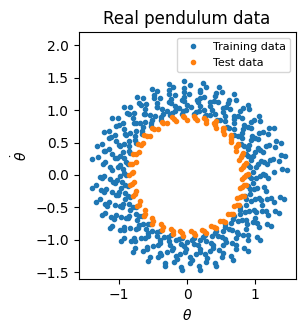

In [14]:
args = get_dhnn_args()
data = get_dhnn_data(args=args)

plt.figure(figsize=[2.8,3.2], dpi=100)
plt.plot(data['x'][:,0], data['x'][:,1], '.', label='Training data')
plt.plot(data['test_x'][:,0], data['test_x'][:,1], '.', label='Test data')
plt.title('Real pendulum data')
plt.xlabel('$\\theta$') ; plt.ylabel('$\dot \\theta$')
plt.legend(fontsize=8, loc='upper right') ; plt.xlim(-1.6,1.6) ; plt.ylim(-1.6,2.2)
plt.show()

In [15]:
# copied form dissipative_hnns, then modified
import time


def get_batch(v, step, args):  # helper function for moving batches of data to/from GPU
  dataset_size, num_features = v.shape
  bix = (step*args.batch_size) % dataset_size
  v_batch = v[bix:bix + args.batch_size, :]  # select next batch
  return torch.tensor(v_batch, requires_grad=True,  dtype=torch.float32, device=args.device)


def dhnn_train(model, args, data):
  """ General training function"""
  model = model.to(args.device)  # put the model on the GPU
  optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.decay)  # setting the Optimizer

  model.train()     # doesn't make a difference for now
  t0 = time.time()  # logging the time
  results = {'train_loss':[], 'test_loss':[], 'test_acc':[], 'global_step':0}  # Logging the results

  for step in range(args.total_steps):  # training loop 

    if use_original_setting:
      # original setting at dhnn
      x, t, dx = [get_batch(data[k], step, args) for k in ['x', 't', 'dx']]

    else:
      # modified setting
      x = torch.tensor(data['x'], requires_grad=True,  dtype=torch.float32, device=args.device)
      t = torch.tensor(data['t'], requires_grad=True,  dtype=torch.float32, device=args.device)
      dx = torch.tensor(data['dx'], requires_grad=True,  dtype=torch.float32, device=args.device)#'''
    
    dx_hat = model(x, t=t)  # feeding forward
    loss = (dx-dx_hat).pow(2).mean()  # L2 loss function
    loss.backward(retain_graph=False); optimizer.step(); optimizer.zero_grad()  # backpropogation

    results['train_loss'].append(loss.item())  # logging the training loss

    # Testing our data with desired frequency (test_every)
    if step % args.test_every == 0:
      # modified setting
      test_x, test_t, test_dx = data['test_x'], data['test_t'], data['test_dx']
      test_x = torch.tensor(data['test_x'], requires_grad=True,  dtype=torch.float32, device=args.device)
      test_t = torch.tensor(data['test_t'], requires_grad=True,  dtype=torch.float32, device=args.device)
      test_dx = torch.tensor(data['test_dx'], requires_grad=True,  dtype=torch.float32, device=args.device)
      test_dx_hat = model(test_x, t=test_t)
      test_loss = (test_dx-test_dx_hat).pow(2).mean().item()

    results['test_loss'].append(test_loss)
    if step % args.print_every == 0:
      print('step {}, dt {:.3f}, train_loss {:.2e}, test_loss {:.2e}'
            .format(step, time.time()-t0, loss.item(), test_loss)) #.item() is just the integer of PyTorch scalar. 
      t0 = time.time()
  model = model.cpu()
  return results

In [16]:
def get_dhnn_model(input_dim, hidden_dim, device='cpu'):
    # Use Andrew Sosanya's implementation as-is.
    from dissipative_hnns.models import DHNN

    model = DHNN(input_dim, hidden_dim) 
    model.to(device) 

    return model

In [17]:
def train_dhnn_main():
    torch.set_grad_enabled(True)

    args = get_dhnn_args()
    args.batch_size = 15
    args.total_steps = 20000
    args.learning_rate = 5e-4
    args.test_every = 500
    args.device = 'cuda'
    [f(args.seed) for f in [np.random.seed, torch.manual_seed, torch.cuda.manual_seed_all]]
    data = get_dhnn_data(args=args)
    model = get_dhnn_model(args.input_dim, args.hidden_dim, args.device)
    stats = dhnn_train(model, args, data)  # training the model
    return model, stats


In [18]:
dhnn_model, dhnn_stats = train_dhnn_main()

save_dir = EXPERIMENT_DIR + "/weights"
save_model_weights(dhnn_model, save_dir,"dhnn_real_with_midpts")


data[trial]: (556, 1)
data[t]: (444, 1)
data[o]: (556, 1)
data[v]: (556, 1)
data[do]: (556, 0)
data[dv]: (556, 0)
data[x]: (444, 2)
data[test_x]: (111, 2)
data[test_t]: (111, 1)
data[dx]: (444, 2)
data[test_dx]: (111, 2)
data[time]: (444, 1)
data[test_time]: (111, 1)
step 0, dt 0.011, train_loss 1.17e+00, test_loss 5.68e-01
step 200, dt 0.508, train_loss 9.00e-03, test_loss 5.68e-01
step 400, dt 0.490, train_loss 2.13e-03, test_loss 5.68e-01
step 600, dt 0.502, train_loss 8.80e-04, test_loss 2.59e-03
step 800, dt 0.881, train_loss 9.81e-03, test_loss 2.59e-03
step 1000, dt 0.903, train_loss 1.06e-03, test_loss 1.56e-03
step 1200, dt 0.853, train_loss 1.73e-03, test_loss 1.56e-03
step 1400, dt 0.504, train_loss 4.00e-03, test_loss 1.56e-03
step 1600, dt 0.491, train_loss 7.50e-03, test_loss 2.16e-03
step 1800, dt 0.351, train_loss 8.71e-04, test_loss 2.16e-03
step 2000, dt 0.361, train_loss 1.84e-03, test_loss 8.54e-04
step 2200, dt 0.357, train_loss 3.08e-03, test_loss 8.54e-04
step 24

# D-HNN2

(Dissipative Hamiltonian NN: modified)

- This modification is similar to HNN architecture of Sam Greydanus

  - 1) This modified architecture now outputs the Hamiltonian.

  - 2) Instead, time-derivative() method is added, just like the original HNN of Sam Greydanus.


In [19]:
"""
Modification of DHNN to DHNN2 architecture 
based on Sam Greydanus' original HNN implementation
"""
class MLP2(torch.nn.Module): 
    def __init__(self, input_dim, output_dim, hidden_dim):
      super(MLP2, self).__init__()
      self.lin_1 = nn.Linear(input_dim, hidden_dim)
      self.lin_2 = nn.Linear(hidden_dim, hidden_dim)
      self.lin_3 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, t=None):
      inputs = torch.cat([x, t], axis=-1) if t is not None else x
      h = self.lin_1(inputs).tanh() 
      h = h + self.lin_2(h).tanh()
      y_hat = self.lin_3(h)
      return y_hat

class DHNN2(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(DHNN2, self).__init__()
        # Since H and D are scalar, we set output_dim=1.
        self.mlp_h = MLP2(input_dim, 1, hidden_dim) 
        self.mlp_d = MLP2(input_dim, 1, hidden_dim) 
        # Levi-Civita permutation tensor M (HNN style)
        self.register_buffer('M', self.permutation_tensor(2))

    def forward(self, x, t=None): 
        """
        Inputs x and t, returns the scalar Hamiltonian (H) and Dissipation (D) functions.
        """
        inputs = torch.cat([x, t], axis=-1) if t is not None else x
        D = self.mlp_d(inputs)
        H = self.mlp_h(inputs)
        return H, D

    def time_derivative(self, x, t=None, as_separate=False):
        """
        Calculates the vector field (dx/dt) using gradients of H and D.
        """
        # Ensures gradient tracking, just like HNN.
        # x tensor should already have requires_grad=True!
        assert x.requires_grad, "Input tensor x must require grad for time_derivative calculation."

        H, D = self.forward(x, t) # output: H and D (scalar)

        # Gradient of H (Symplectic gradient)
        dHdx = torch.autograd.grad(H.sum(), x, create_graph=True)[0]
        # Computes the rotational component of the J * dHdx form (J: symplectic matrix)
        rot_component = dHdx @ self.M.t()

        # Gradient of D (Irrotational gradient)
        dDdx = torch.autograd.grad(D.sum(), x, create_graph=True)[0]
        irr_component = dDdx

        if as_separate:
            return irr_component, rot_component

        return irr_component + rot_component

    def permutation_tensor(self, n):
        # permutation_tensor implementation of the original HNN code
        M = torch.eye(n)
        # assuming canonical coordinates [q, p]
        M = torch.cat([M[n//2:], -M[:n//2]])
        return M

In [20]:
# simplifies accessing the hyperparameters.
class ObjectView(object):
    def __init__(self, d): self.__dict__ = d
    
def get_dhnn2_args(as_dict=False):
  arg_dict = {'input_dim': 3,
              'hidden_dim': 256, # capacity
              'output_dim': 2,
              'learning_rate': 1e-2, 
              'test_every': 100,
              'print_every': 200,
              'batch_size': 128,
              'train_split': 0.80,  # train/test dataset percentage
              'total_steps': 5000,  # because we have a synthetic dataset
              'device': 'cuda', # {"cpu", "cuda"} for using GPUs
              'seed': 42,
              'as_separate': False,
              'decay': 0,
              'verbose': True}
  return arg_dict if as_dict else ObjectView(arg_dict)

In [21]:
def get_dhnn2_model(device='cpu'):
    args = get_dhnn2_args()    
    model = DHNN2(args.input_dim, args.hidden_dim) 
    model.to(device) 
    return model

In [22]:
def get_batch2(v, step, args):  # helper function for moving batches of data to/from GPU
  dataset_size, num_features = v.shape
  bix = (step*args.batch_size) % dataset_size
  v_batch = v[bix:bix + args.batch_size, :]  # select next batch
  return torch.tensor(v_batch, requires_grad=True,  dtype=torch.float32, device=args.device)


def dhnn2_train():
    # adapted to the current directory structures.
    from hamiltonian_nn.utils import L2_loss

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = get_dhnn2_model(device)

    model.train()

    # Check if model's parameters is updatable
    for param in model.parameters():
       assert param.requires_grad, "Model parameters must require grad for training."

    args = get_dhnn2_args()

    # set random seed
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)

    # Adam optimizer
    optim = torch.optim.Adam(model.parameters(), args.learning_rate, weight_decay=1e-5)

    # arrange data (dataset loading)
    args = get_dhnn2_args()
    data = get_dhnn_data(args)
    
    x = torch.tensor( data['x'], requires_grad=True, dtype=torch.float32, device=device)
    t = torch.tensor( data['t'], requires_grad=True, dtype=torch.float32, device=device)
    dx = torch.tensor(data['dx'], dtype=torch.float32, device=device) 

    test_x = torch.tensor( data['test_x'], requires_grad=True, dtype=torch.float32, device=device)
    test_t = torch.tensor( data['test_t'], requires_grad=True, dtype=torch.float32, device=device)
    test_dx = torch.tensor(data['test_dx'], dtype=torch.float32, device=device) 

    # vanilla train loop
    stats = {'train_loss': [], 'test_loss': []}
    for step in range(args.total_steps+1):

        # train step

        # Check the 'requires_grad' property of x tensor
        assert x.requires_grad, "Input tensor x must require grad for training." 

        # Use DHNN2's time_derivative() method (instead of DNN's forward())
        dx_hat = model.time_derivative(x, t=t) # We have to pass 't' also as an argument!
        loss = L2_loss(dx, dx_hat)
        loss.backward() ; optim.step() ; optim.zero_grad()

        # run validation (use with torch.no_grad())
        test_dx_hat = model.time_derivative(test_x, test_t) # We have to pass 'test_t' also as an argument!
        test_loss = L2_loss(test_dx, test_dx_hat)

        # logging
        stats['train_loss'].append(loss.item())
        stats['test_loss'].append(test_loss.item())
        if args.verbose and step % args.print_every == 0:
            print("step {}, train_loss {:.4e}, test_loss {:.4e}".format(step, loss.item(), test_loss.item()))

    # Final evaluation
    train_dx_hat = model.time_derivative(x,t) # We should pass 't' also as an argument!
    train_dist = (dx - train_dx_hat)**2
    test_dx_hat = model.time_derivative(test_x, test_t) # We should pass 't' also as an argument!
    test_dist = (test_dx - test_dx_hat)**2
        
    print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
          .format(train_dist.mean().item(), train_dist.std().item()/np.sqrt(train_dist.shape[0]),
                  test_dist.mean().item(), test_dist.std().item()/np.sqrt(test_dist.shape[0])))

    # After trainin finished, we switch the global grad tracking state back to the True (default)
    torch.set_grad_enabled(True) 
    
    return model, stats

In [23]:
dhnn2_model, dhhn2_stats = dhnn2_train()
save_dir = EXPERIMENT_DIR + "/weights"
save_model_weights(dhnn2_model, save_dir,"dhnn2_real")

data[trial]: (556, 1)
data[t]: (444, 1)
data[o]: (556, 1)
data[v]: (556, 1)
data[do]: (556, 0)
data[dv]: (556, 0)
data[x]: (444, 2)
data[test_x]: (111, 2)
data[test_t]: (111, 1)
data[dx]: (444, 2)
data[test_dx]: (111, 2)
data[time]: (444, 1)
data[test_time]: (111, 1)
step 0, train_loss 9.0422e-01, test_loss 2.9717e+01
step 200, train_loss 5.5624e-04, test_loss 1.7292e-03
step 400, train_loss 4.9889e-04, test_loss 1.1962e-03
step 600, train_loss 4.8536e-04, test_loss 9.9881e-04
step 800, train_loss 4.8124e-04, test_loss 8.9049e-04
step 1000, train_loss 4.8107e-04, test_loss 8.2493e-04
step 1200, train_loss 5.2870e-04, test_loss 8.3898e-04
step 1400, train_loss 4.8577e-04, test_loss 7.6563e-04
step 1600, train_loss 4.8687e-04, test_loss 7.4845e-04
step 1800, train_loss 4.8971e-04, test_loss 7.5382e-04
step 2000, train_loss 4.9649e-04, test_loss 7.4196e-04
step 2200, train_loss 4.9264e-04, test_loss 7.3067e-04
step 2400, train_loss 4.9629e-04, test_loss 7.5195e-04
step 2600, train_loss 4.

# HNN2

(Hamiltonian NN modified for GPU support)

- The original HNN written by Sam Greydaus is not GPU-trainable

- DGNet, D-HNN are trained on the same torch GPU context, so HNN also needs to be GPU-trainable

- 

In [24]:
def get_hnn2_args():
    parser = argparse.ArgumentParser(description=None)
    parser.add_argument('--input_dim', default=2, type=int, help='dimensionality of input tensor')
    parser.add_argument('--hidden_dim', default=200, type=int, help='hidden dimension of mlp')
    parser.add_argument('--learn_rate', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--nonlinearity', default='tanh', type=str, help='neural net nonlinearity')
    parser.add_argument('--total_steps', default=2000, type=int, help='number of gradient steps')
    parser.add_argument('--print_every', default=200, type=int, help='number of gradient steps between prints')
    parser.add_argument('--verbose', dest='verbose', action='store_true', help='verbose?')
    parser.add_argument('--name', default='real', type=str, help='name of the task')
    parser.add_argument('--field_type', default='solenoidal', type=str, help='type of vector field to learn')
    parser.add_argument('--baseline', dest='baseline', action='store_true', help='run baseline or experiment?')
    parser.add_argument('--use_rk4', dest='use_rk4', action='store_true', help='integrate derivative with RK4')
    parser.add_argument('--seed', default=0, type=int, help='random seed')
    parser.add_argument('--save_dir', default=EXPERIMENT_DIR, type=str, help='where to save the trained model')
    parser.set_defaults(feature=True)

    if is_jupyter():
        return parser.parse_args([]) 
    else:
        return parser.parse_args()

In [25]:
"""
Modification of HNN to the GPU trainable model HNN2
"""
class HNN2(torch.nn.Module):
    '''Learn arbitrary vector fields that are sums of conservative and solenoidal fields'''
    def __init__(self, input_dim, differentiable_model, field_type='solenoidal',
                    baseline=False, assume_canonical_coords=True):
        super(HNN2, self).__init__()
        self.baseline = baseline
        self.differentiable_model = differentiable_model
        self.assume_canonical_coords = assume_canonical_coords
        self.field_type = field_type

        # --- Modification 1 for GPU support: register_buffer() is used ---
        # self.M = self.permutation_tensor(input_dim) # original HNN code
        M_tensor = self.permutation_tensor(input_dim)
        self.register_buffer('M_buffer', M_tensor) # M tensor is registered as buffer
        
    def forward(self, x):
        # traditional forward pass
        if self.baseline:
            return self.differentiable_model(x)

        y = self.differentiable_model(x)
        assert y.dim() == 2 and y.shape[1] == 2, "Output tensor should have shape [batch_size, 2]"
        return y.split(1,1)

    ''' 
    Omitted (out of the current interest).
       - rk4 function needs to be modified to GPU supporting version 
       - or torchdiffeq should be used
    '''
    # def rk4_time_derivative(self, x, dt):
    #    return rk4(fun=self.time_derivative, y0=x, t=0, dt=dt)'''

    def time_derivative(self, x, t=None, separate_fields=False):
        '''NEURAL ODE-STLE VECTOR FIELD'''
        if self.baseline:
            return self.differentiable_model(x)

        '''NEURAL HAMILTONIAN-STLE VECTOR FIELD'''
        F1, F2 = self.forward(x) # traditional forward pass

        # --- Modification 2 for GPU support: In tensor creation, use x's device ---
        conservative_field = torch.zeros_like(x, device=x.device) # device=x.device added
        solenoidal_field = torch.zeros_like(x, device=x.device) # device=x.device added

        if self.field_type != 'solenoidal':
            dF1 = torch.autograd.grad(F1.sum(), x, create_graph=True)[0] # gradients for conservative field
            # self.M_buffer와 동일한 장치에 eye 생성
            eye = torch.eye(*self.M_buffer.shape, device=self.M_buffer.device)
            conservative_field = dF1 @ eye

        if self.field_type != 'conservative':
            dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0] # gradients for solenoidal field
            # Use self.M_buffer
            solenoidal_field = dF2 @ self.M_buffer.t()

        if separate_fields:
            return [conservative_field, solenoidal_field]

        return conservative_field + solenoidal_field

    def permutation_tensor(self, n):
        # Returns torch tensor, and processed at __init__
        M = None
        if self.assume_canonical_coords:
            M = torch.eye(n)
            M = torch.cat([M[n//2:], -M[:n//2]])
        else:
            M = torch.ones(n,n)
            M *= 1 - torch.eye(n)
            M[::2] *= -1
            M[:,::2] *= -1
            for i in range(n):
                for j in range(i+1, n):
                    M[i,j] *= -1
        return M

In [26]:
def get_hnn2_model(device):
    """
    Definitions of MLP class at hamiltonian_nn and at dissipative_hnns DIFFER!
    We need hamitonian_nn's MLP implementation.
    """
    from hamiltonian_nn.nn_models import MLP

    args = get_hnn2_args()
    output_dim = args.input_dim
    nn_model = MLP(args.input_dim, args.hidden_dim, output_dim, args.nonlinearity)
    # Modified HNN class above (HNN2: GPU sersion) is used)
    model = HNN2(args.input_dim, differentiable_model=nn_model,
              field_type=args.field_type) 
    model.to(device) 
    return model

In [27]:
def hnn2_train():
  # adapted to the current hnn-family directory sturctures
  from hamiltonian_nn.utils import L2_loss

  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  args = get_hnn2_args()
  args.verbose = True
  
  model = get_hnn2_model(device)

  # set random seed
  torch.manual_seed(args.seed)
  np.random.seed(args.seed)

  optim = torch.optim.Adam(model.parameters(), args.learn_rate, weight_decay=1e-5)

  # arrange data
  data = get_dataset('pend-real', args.save_dir)
  
  # Changed torch.Tensor() of the original HNN to torch.tensor() in HNN2 for GPU support.
  x = torch.tensor( data['x'], requires_grad=True, dtype=torch.float32, device=device)
  dx = torch.tensor(data['dx'], dtype=torch.float32, device=device) 

  test_x = torch.tensor( data['test_x'], requires_grad=True, dtype=torch.float32, device=device)
  test_dx = torch.tensor(data['test_dx'], dtype=torch.float32, device=device) 

  # vanilla train loop
  stats = {'train_loss': [], 'test_loss': []}
  for step in range(args.total_steps+1):

    # train step
    dx_hat = model.time_derivative(x)
    loss = L2_loss(dx, dx_hat)
    loss.backward() ; optim.step() ; optim.zero_grad()

    # run validation
    test_dx_hat = model.time_derivative(test_x)
    test_loss = L2_loss(test_dx, test_dx_hat)

    # logging
    stats['train_loss'].append(loss.item())
    stats['test_loss'].append(test_loss.item())
    if args.verbose and step % args.print_every == 0:
      print("step {}, train_loss {:.4e}, test_loss {:.4e}".format(step, loss.item(), test_loss.item()))

  train_dx_hat = model.time_derivative(x)
  train_dist = (dx - train_dx_hat)**2
  test_dx_hat = model.time_derivative(test_x)
  test_dist = (test_dx - test_dx_hat)**2
  print('Final train loss {:.4e} +/- {:.4e}\nFinal test loss {:.4e} +/- {:.4e}'
    .format(train_dist.mean().item(), train_dist.std().item()/np.sqrt(train_dist.shape[0]),
            test_dist.mean().item(), test_dist.std().item()/np.sqrt(test_dist.shape[0])))

  return model, stats

In [28]:
hnn2_model, stats = hnn2_train()
save_dir = EXPERIMENT_DIR + "/weights"
save_model_weights(hnn2_model, save_dir,"hnn2_real")

data zip filepath: ./experiment-real/invar_datasets.zip
step 0, train_loss 7.6955e-01, test_loss 4.5178e-01
step 200, train_loss 9.2908e-03, test_loss 6.0311e-03
step 400, train_loss 9.1878e-03, test_loss 5.8373e-03
step 600, train_loss 9.1703e-03, test_loss 5.8074e-03
step 800, train_loss 9.1651e-03, test_loss 5.8024e-03
step 1000, train_loss 9.1623e-03, test_loss 5.8015e-03
step 1200, train_loss 9.1603e-03, test_loss 5.8013e-03
step 1400, train_loss 9.1587e-03, test_loss 5.7976e-03
step 1600, train_loss 9.1572e-03, test_loss 5.8020e-03
step 1800, train_loss 9.1558e-03, test_loss 5.8023e-03
step 2000, train_loss 9.1558e-03, test_loss 5.7980e-03
Final train loss 9.1548e-03 +/- 4.9165e-04
Final test loss 5.7980e-03 +/- 6.0307e-04
Model's weight has successfully been saved: ./experiment-real/weights/hnn2_real.pth
